In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model import ode_y, ode_z
from numba import njit

**ODE for y**:
\begin{align*}
0 = \max_{\tilde{e}} \min_h \min_{\pi_i^c, \sum_{i=1}^n \pi^c_i=1} &  -\delta \phi(y) + \delta \eta \log \tilde{e} \\
&+ \frac{d\phi(y)}{dy}\tilde{e}(\sum_{i=1}^n \pi_i^c \theta_i + \sigma_y \cdot h) + \frac{1}{2} \frac{d^2 \phi(y)}{(d y)^2}|\sigma_y|^2(\tilde{e})^2\\
& + (\eta-1)\left[\gamma_1 + \gamma_2 y + \gamma_2^+\boldsymbol{1}_{y\geq \bar{y}}(y-\bar{y})\right]\tilde{e}(\sum_{i=1}^n \pi_i^c\theta_i + \sigma_y \cdot h)\\
& + (\eta-1)\left[\frac{1}{2}\left(\gamma_2 + \gamma_2^+\boldsymbol{1}_{y\geq \bar{y}}\right)\right]|\sigma_y|^2(\tilde{e})^2\\
& +\frac{\xi_{1,m}}{2}h^\prime h + \xi_a\sum_{i=1}^{n} \pi_i^c(\log \pi_i^c - \log \hat{\pi}_i^c)
\end{align*}


The FOC of $h$ gives:
$$
h^* = -\frac{\left(\frac{d\phi(y)}{dy} + (\eta-1)\left[\gamma_1 + \gamma_2 y + \gamma_2^+\boldsymbol{1}_{y\geq \bar{y}}(y-\bar{y})\right]\right)\tilde{e}\sigma_y}{\xi_{1,m}}
$$


Substitute $h$ with $h^*$ in the ODE:

\begin{align*}
0 = \max_{\tilde{e}} & -\delta \phi(y) + \delta \eta \log \tilde{e} \\
& + G(y)\tilde{e} \sum_{i=1}^n\pi_i^c\theta_i + \frac{1}{2} \left(F(y)-\frac{G^2(y)}{\xi_{1,m}}\right)|\sigma_y|^2(\tilde{e})^2\\
& + \xi_a\sum_{i=1}^{n} \pi_i^c(\log \pi_i^c - \log \hat{\pi}_i^c)\\
\end{align*}

where $G(y):=\frac{d\phi(y)}{dy} + (\eta-1)\left[\gamma_1 + \gamma_2 y + \gamma_2^+\boldsymbol{1}_{y\geq \bar{y}}(y-\bar{y})\right]$, $F(y):=\frac{d^2 \phi(y)}{(d y)^2} + (\eta-1)\left(\gamma_2 + \gamma_2^+\boldsymbol{1}_{y\geq \bar{y}}\right)$.

The FOC of $\tilde{e}$ gives:
$$
\tilde{e}^* = \frac{-\sum_{i=1}^n\pi^c_i \theta_i G(y) - \sqrt{\left(\sum_{i=1}^n \pi_i^c \theta_i\right)^2G^2(y)-4\delta \eta |\sigma_y|^2\left(F(y)-\frac{G^2(y)}{\xi_{1,m}}\right)}}{2|\sigma_y|^2\left(F(y)-\frac{G^2(y)}{\xi_{1,m}}\right)}
$$

In addition, the FOC of $\pi^c$ gives:
$$
\pi_i^c \propto \exp \left[-\frac{1}{\xi_a}G(y)\tilde{e}\theta_i\right]\hat{\pi}^c_i
$$

In [42]:
ξ_1m = 1000.
ξ_a = 1./4000

η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*1.86/1000

y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = 0*.5 + .0197*2*.5 # weighted model of low and high

n_y = 200
y_min = 0.
y_max = 10.
y_grid = np.linspace(y_min, y_max, n_y)

model_paras = (η, δ, θ, πc_o, σ_y, ξ_1m, ξ_a, γ_1, γ_2, γ_2p, y_bar) 
model_res = ode_y(y_grid, model_paras, v0=None, ϵ=.5,
                                  tol=1e-8, max_iter=5_000, print_all=False)

Converged. Total iteration 1750: LHS Error: 9.9567402933598e-09; RHS Error 5.426437403502522e-06


In [43]:
def simulation(y_grid, e_grid, θ=1.86/1000., y_start=.5394, T=100):
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid)
        yt[i] = y_start
        y_start = y_start + Et[i]*θ
    return Et, yt

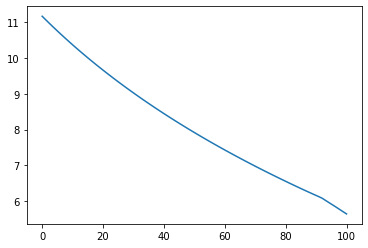

In [44]:
et, _ = simulation(y_grid, model_res['e_tilde'])
plt.plot(et)

In [46]:
et[0]

11.158413766865515

**ODE for z**:
$$
0 = \min_h -\delta \eta \log z_2 + \frac{\xi_{1,m}}{2}h^\prime h + \frac{d\psi(z_2)}{d z_2}\left[-\rho(z_2-\mu_2) + \sqrt{z_2}\sigma_2 \cdot h\right] + \frac{1}{2}\frac{d^2 \psi(z_2)}{(d z_2)^2}z_2|\sigma_2|^2
$$

The FOC of $h$ gives:
$$
h^* = -\frac{\frac{d\psi(z_2)}{d z_2}\sqrt{z_2}\sigma_2}{\xi_{1,m}}
$$

In [ ]:
# Model parameters
η = .032
δ = .01

ρ = 0.9
μ_2 = 1.
σ_2 = 0.013145579 / np.sqrt(1.86/1000)

ξ_1m = 1000.

n_z = 100
z_min = np.max([μ_2 - 3*np.sqrt(σ_2**2*μ_2/(2*ρ)), 1e-9])
z_max = μ_2 + 3*np.sqrt(σ_2**2*μ_2/(2*ρ))
z_grid = np.linspace(z_min, z_max, n_z)

model_paras = (η, δ, ρ, μ_2, σ_2, ξ_1m) 
ψ = ode_z(z_grid, model_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=2_000)

In [ ]:
plt.plot(z_grid, ψ)